In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Helper function

In [127]:
def check_uniques(df, threshold=None):
    unique_stats = df.nunique(axis=0)

    if np.all(unique_stats == len(df)):
        print('All columns have the unique values!')
    else:
        if threshold:
            cutted_unique_stats = unique_stats[unique_stats < threshold] 
        else:
            cutted_unique_stats = unique_stats

        fig, ax = plt.subplots(figsize=(6, 6))
        sns.set_color_codes("muted") 
        sns.barplot(x=cutted_unique_stats.values, y=cutted_unique_stats.index, color='b')
        plt.show()

        
# === Diagnosis ===
def check_duplicated(df, remove=False):
    duplicated_flag = df.duplicated()

    if sum(duplicated_flag) > 0:
        print(f"{sum(df.duplicated())} duplicated rows!")

        print('Remove duplicates...')

        df = df.drop_duplicates()
        check_duplicated(df)
        return df
    else:
        print('No duplicated rows!')

    # return duplicated_flag


def check_missing(df):
    null_values_stats = df.isnull().sum(axis=0) # for each column
    
    if np.all(null_values_stats == 0):
        print('No missing values!')
    else:
        zero_null_values_stats = (null_values_stats / len(df)).sort_values(ascending=False)

        fig, ax = plt.subplots(figsize=(6, 6))
        sns.set_color_codes("muted")
        sns.barplot(x=zero_null_values_stats.values, y=zero_null_values_stats.index, color='b')
        plt.show()

        
def missing_heatmap(df):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(df.isna())
    plt.show()

    
def check_column_missing(column):
    missing_counts = column.isna().sum()
    filled_counts = len(column) - missing_counts
    
    if missing_counts == 0:
        print('No missing values !')
    else:
        stats = {
            'missing': missing_counts,
            'filled': filled_counts
        }
        stats_ser = pd.Series(data=stats, index=stats.keys())

        fig, ax = plt.subplots()
        sns.barplot(x=stats_ser.index, y=stats_ser.values)
        plt.show()

def dropColumns(df, columns):
    print('Droping columns...')
    return df.drop(columns, axis=1)


def removeMissingColumns(data, proportion = .4, white_list=None):
    """
    Remove missing columns where more than 40% of the values are null
    """
    null_stats = data.isnull().sum(axis=0)

    missing_columns = []
    for col in null_stats.keys():
        if null_stats[col] / len(data) >= proportion and (white_list is None or col not in white_list):
            missing_columns.append(col)

    print('Remove missing columms:', missing_columns)

    data = dropColumns(data, missing_columns)

    return data


def cutIQR(cleaned_df, col):
    print('Remove outliers...')

    Q1 = cleaned_df[col].quantile(0.25)
    Q3 = cleaned_df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    cutted_df = cleaned_df[(cleaned_df[col] >= lower) & (cleaned_df[col] <= upper)]

    return cutted_df, upper


def type_cast(df, columns=None, types=None):
    
    """
    columns: an array of list of fields with the same type,
    types: an array of strings that indicates the type to be casted

    for example: 
        type_cast(df, [
            ['year', 'month'], 
            ['grade', 'weather']
        ], ['datetime64', 'category'])
    """

    for i, same_type_col in enumerate(columns):
        for col in same_type_col:
            df[col] = df[col].astype(types[i])

    print('Type casting done.')

    
    
# === EDA for categorical variables ===
def categorical_counts_stats(df, N = 5):
    """
    print the counts of unique values for categorical and object values.
    """

    columns = df.select_dtypes(include=['object', 'category']).columns
    print(f'There are {len(columns)} categorical variables!')

    for col in columns:
        print("Categrorical variable: " + col)

        cate_counts = df[col].value_counts()
        cate_len = len(cate_counts)

        # reshape
        cate_counts = cate_counts.reset_index().rename(columns={"index": col, col: "Count"})

        print(cate_counts[:min(N, cate_len)])
    

def categorical_eda(df, columns=None, hue=None):
    """
    Plot count distribution of categorical data
    """

    # categorical_counts_stats(df)

    if columns is None:
        columns = df.select_dtypes(include='category').columns
    
    col = 2
    row = (len(columns) // col) + (0 if len(columns)%col==0 else 1)
    fig, ax = plt.subplots(row, col, figsize=(14, 4*row), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
    for i, column in enumerate(columns):
        ax_i = ax[i//col, i%col]
        g = sns.countplot(data=df, x=column, hue=hue, ax=ax_i)
        g.set_xticklabels(ax_i.get_xticklabels(), rotation=20)
        ax_i.yaxis.label.set_visible(False)

    plt.show()


# 1. Read the data

In [47]:

df_vehicles = pd.read_csv('./data/vehicles.csv')


In [48]:
df_vehicles = df_vehicles.drop(['Unnamed: 0'], axis=1)


In [49]:
df_vehicles.shape


(458213, 25)

In [50]:
df_vehicles.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458213 entries, 0 to 458212
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            458213 non-null  int64  
 1   url           458213 non-null  object 
 2   region        458213 non-null  object 
 3   region_url    458213 non-null  object 
 4   price         458213 non-null  int64  
 5   year          457163 non-null  float64
 6   manufacturer  439993 non-null  object 
 7   model         453367 non-null  object 
 8   condition     265273 non-null  object 
 9   cylinders     287073 non-null  object 
 10  fuel          454976 non-null  object 
 11  odometer      402910 non-null  float64
 12  title_status  455636 non-null  object 
 13  transmission  455771 non-null  object 
 14  VIN           270664 non-null  object 
 15  drive         324025 non-null  object 
 16  size          136865 non-null  object 
 17  type          345475 non-null  object 
 18  pain

In [51]:
df_vehicles.head(3)


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,state,lat,long,posting_date
0,7240372487,https://auburn.craigslist.org/ctd/d/auburn-uni...,auburn,https://auburn.craigslist.org,35990,2010.0,chevrolet,corvette grand sport,good,8 cylinders,...,rwd,NaN,other,NaN,https://images.craigslist.org/00N0N_ipkbHVZYf4...,Carvana is the safer way to buy a car During t...,al,32.590000,-85.480000,2020-12-02T08:11:30-0600
1,7240309422,https://auburn.craigslist.org/cto/d/auburn-201...,auburn,https://auburn.craigslist.org,7500,2014.0,hyundai,sonata,excellent,4 cylinders,...,fwd,NaN,sedan,NaN,https://images.craigslist.org/00s0s_gBHYmJ5o7y...,I'll move to another city and try to sell my c...,al,32.547500,-85.468200,2020-12-02T02:11:50-0600
2,7240224296,https://auburn.craigslist.org/cto/d/auburn-200...,auburn,https://auburn.craigslist.org,4900,2006.0,bmw,x3 3.0i,good,6 cylinders,...,NaN,NaN,SUV,blue,https://images.craigslist.org/00B0B_5zgEGWPOrt...,Clean 2006 BMW X3 3.0I. Beautiful and rare Bl...,al,32.616807,-85.464149,2020-12-01T19:50:41-0600


## Unique values

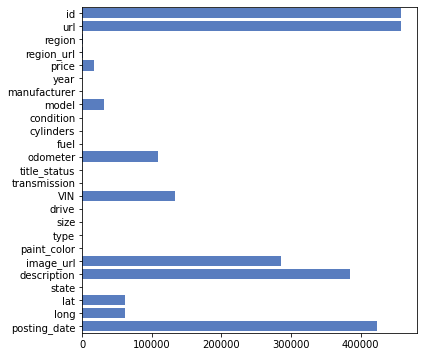

In [52]:
check_uniques(df_vehicles)


## Missing values

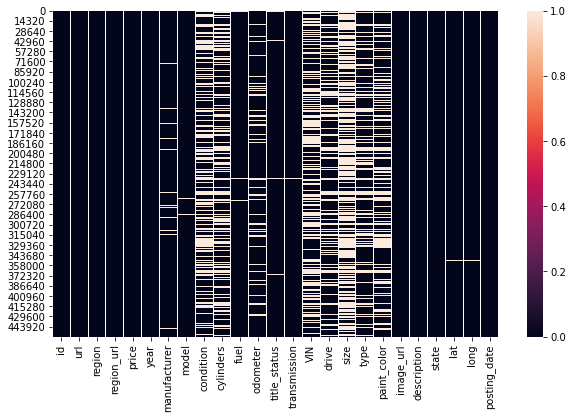

In [53]:
missing_heatmap(df_vehicles)


- condition, cylinders, odometer, VIN, drive, size, type, paint_color columns are almost filled with missing values.



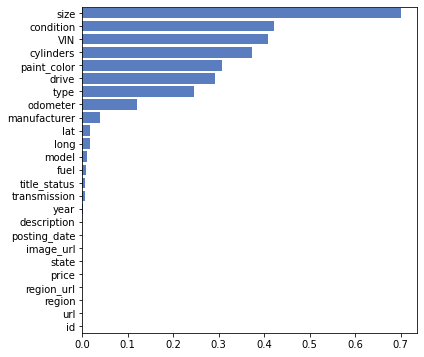

In [54]:
check_missing(df_vehicles)


## Outliers

In [55]:
df_vehicles.describe().apply(lambda s: s.apply('{0:.2f}'.format))


,id,price,year,odometer,lat,long
count,458213.00,458213.00,457163.00,402910.00,450765.00,450765.00
mean,7235233427.48,40420.93,2010.75,101669.76,38.53,-94.38
std,4594362.05,8194598.60,8.87,3228622.54,5.86,18.08
min,7208549803.00,0.00,1900.00,0.00,-82.61,-164.09
25%,7231952523.00,4900.00,2008.00,40877.00,34.60,-110.89
50%,7236408504.00,10995.00,2013.00,87641.00,39.24,-88.31
75%,7239320847.00,21495.00,2016.00,134000.00,42.48,-81.02
max,7241019367.00,3615215112.00,2021.00,2043755555.00,82.05,150.90


### Price

Remove outliers...


<AxesSubplot:>

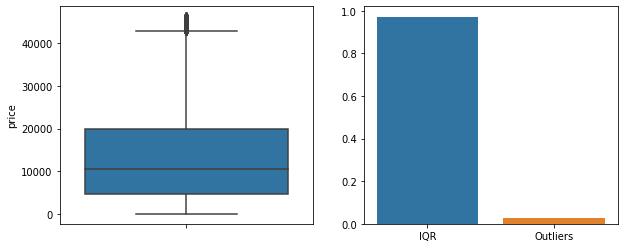

In [56]:
cutted_price, upper_price = cutIQR(df_vehicles, 'price')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# plot 1
sns.boxplot(data=cutted_price, y='price', ax=ax[0])

# plot 2
price_counts_df = pd.DataFrame({
    'IQR': [len(cutted_price) / len(df_vehicles)],
    'Outliers': [np.sum(cleaned_df['price'] > upper_price) / len(df_vehicles)]
})
sns.barplot(data=price_counts_df, ax=ax[1])


### Odometer

Remove outliers...


<AxesSubplot:>

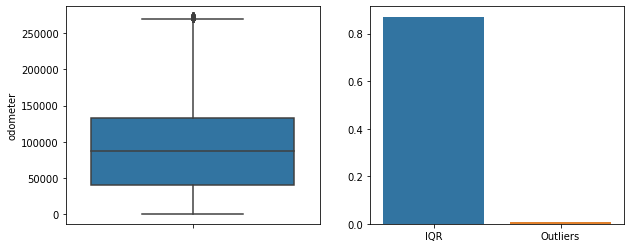

In [57]:
cutted_odometer, upper_odometer = cutIQR(df_vehicles, 'odometer')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# plot 1
sns.boxplot(data=cutted_odometer, y='odometer', ax=ax[0])

# plot 2
odometer_counts_df = pd.DataFrame({
    'IQR': [len(cutted_odometer) / len(df_vehicles)],
    'Outliers': [np.sum(cleaned_df['odometer'] > upper_odometer) / len(df_vehicles)]
})
sns.barplot(data=odometer_counts_df, ax=ax[1])


## Duplicated rows

In [76]:

check_duplicated(df_vehicles)


No duplicated rows.


## Useless columns

- 'id', 'url', 'region_url', 'image_url' are entirely irrelavant to the cars' price


- model -> too many categories, cannot be converted to dummy variables.


TODO:
- description -> NLP, keep it


- region, state -> may equavilent to 'lat', 'ong'


- paint_color -> might have little influence on the cars' price


# 2. Clean the Data

In [88]:
cat_features = [
    'region', 'state', # region(405), state(51), 
    'manufacturer', 'condition', 'cylinders', 
    'fuel', 'title_status', 'transmission', 
    'drive', 'type', 'paint_color'  
]

num_features = ['odometer', 'lat', 'long']

time_features = ['year', 'posting_date']

text_features = ['description']


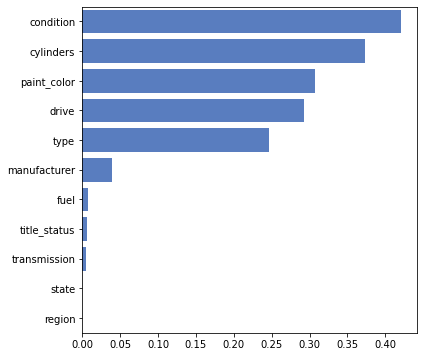

In [96]:
check_missing(df_vehicles[cat_features])


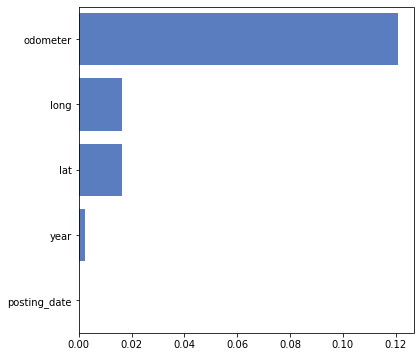

In [97]:
check_missing(df_vehicles[time_features + num_features])


In [ ]:
def cleanData(df):
    # Useless
    cleaned_df = removeMissingColumns(df, white_list=['condition']) # remove 40%
    cleaned_df = dropColumns(cleaned_df, 
                             ['id', 'url', 'region_url', 'image_url', 'model', 
                              'region', 'state'
                             ] + text_features)

    # Outliers
    cleaned_df, _ = cutIQR(cleaned_df, 'odometer')
    cleaned_df, _ = cutIQR(cleaned_df, 'price')
    

    # Missing 
    # for categorical:
    cleaned_df[cat_features[2:]] = cleaned_df[cat_features[2:]].fillna('unknown')
    # for time: remove the rows
    cleaned_df = cleaned_df[~cleaned_df['year'].isna()]
    cleaned_df = cleaned_df[~cleaned_df['posting_date'].isna()]
    # for numerical: odometer, lat, long, filled with mean value
    cleaned_df[num_features] = cleaned_df[num_features].fillna(cleaned_df[num_features].mean())

    
    # diagnosis
    cleaned_df = check_duplicated(cleaned_df)
    check_missing(cleaned_df)

    return cleaned_df


In [110]:

df = cleanData(df_vehicles)


Remove missing columms: ['VIN', 'size']
Droping columns...
Droping columns...
Remove outliers...
Remove outliers...
158 duplicated rows!
Remove duplicates...
No duplicated rows.
No missing values!


# 3. EDA


## Categorical Distribution

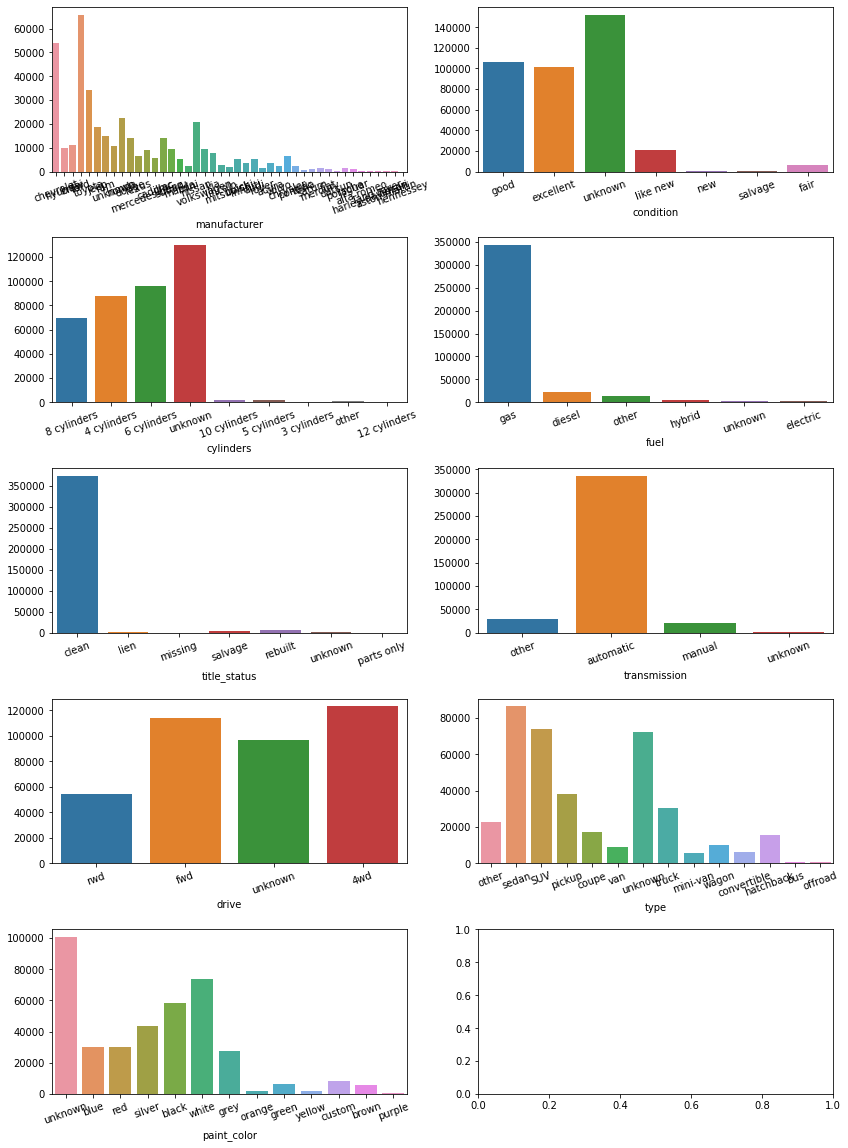

In [112]:

categorical_eda(df, columns = cat_features[2:])


## Correlation

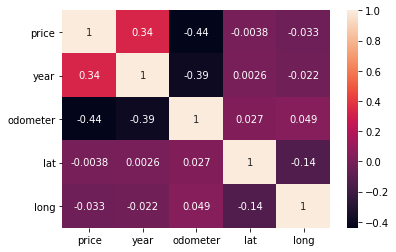

In [114]:
corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True)

plt.show()


- year is positive correlated with price



- odometer is negative correlated with price


## By Year

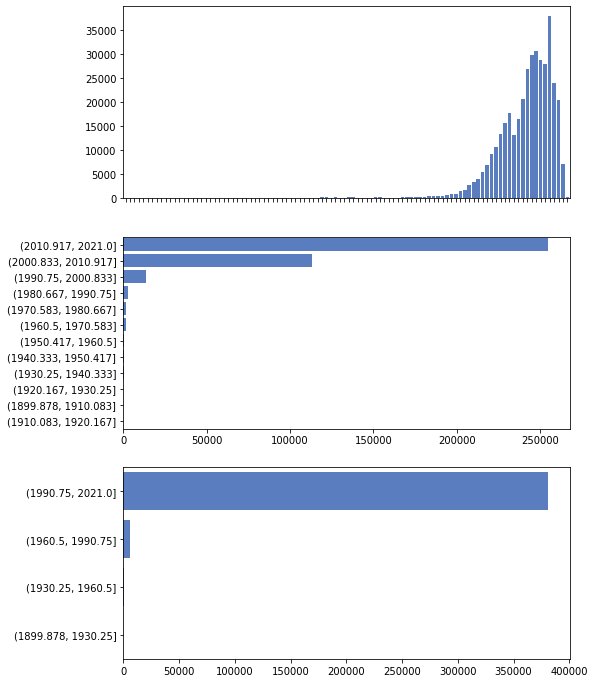

In [116]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
sns.set_color_codes("muted") 


year_counts = df['year'].value_counts()
g=sns.barplot(x=year_counts.index, y=year_counts.values, color='b', ax=ax[0])
ax[0].set_xticklabels([])


decades_counts = df['year'].value_counts(bins=12)
g=sns.barplot(x=decades_counts.values, y=decades_counts.index, color='b', ax=ax[1])


thirty_counts = df['year'].value_counts(bins=4)
g=sns.barplot(x=thirty_counts.values, y=thirty_counts.index, color='b', ax=ax[2])

# after_2000_counts = df[(df['year'] >= 2000) & (df['year'] <= 2021) ]['year'].value_counts()
# sns.barplot(x=after_2000_counts.index, y=after_2000_counts.values, color='b', ax=ax[2])
# ax[2].set_xticklabels([])

# before_2000_counts = df[df['year'] < 2000]['year'].value_counts()
# sns.barplot(x=before_2000_counts.index, y=before_2000_counts.values, color='b', ax=ax[3])
# ax[3].set_xticklabels([])

plt.show()


- Most used cars were made from 2000 to 2021.



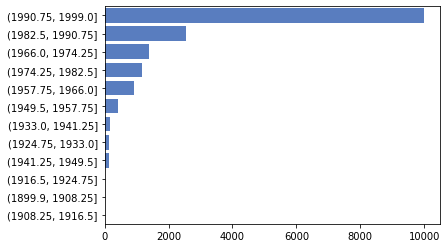

In [117]:
year_counts = df[df['year'] < 2000]['year'].value_counts(bins=12)

fig, ax = plt.subplots()
sns.set_color_codes("muted") 
sns.barplot( x=year_counts.values, y=year_counts.index, color='b')
plt.show()


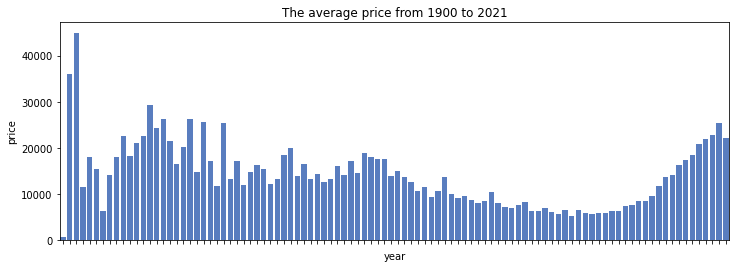

In [118]:
avg_price_by_year = df.groupby('year')['price'].mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 4))
sns.set_color_codes("muted") 
g=sns.barplot(data=avg_price_by_year, x='year', y='price', color='b')
g.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_xticklabels([])
ax.set_title('The average price from 1900 to 2021')
plt.show()


<AxesSubplot:xlabel='year', ylabel='price'>

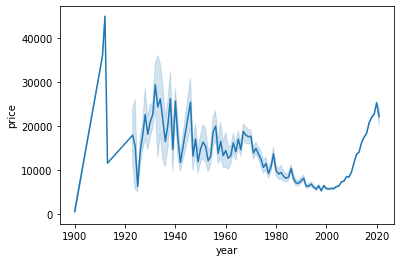

In [338]:
sns.lineplot(data=df, x='year', y = 'price')


- Antique cars (over 100 years) are the most expensive cars


- The price of cars made between 1920 and 1960 fluctuate significantly.


- After 1960, the price decreased constantly until 2000.


- The newer the cars are, the more expensive the price in the recent 20 years.



## By paint color

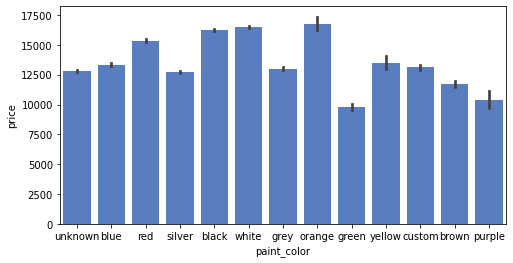

In [119]:

avg_price_by_paint_color = df.groupby(['paint_color'])['price'].mean().reset_index()

fig, ax = plt.subplots(figsize=(8, 4))
sns.set_color_codes("muted") 
sns.barplot(data=df, x='paint_color', y='price', color='b')
plt.show()


# 4. Preparation

## Dummy variables 


In [165]:
def transformData(df):
    # date time
    posting_date = pd.to_datetime(df['posting_date'], utc=True)
    df['post_year'] = posting_date.dt.year
    df['post_month'] = posting_date.dt.month
    df['post_mday'] = posting_date.dt.day
    df = dropColumns(df, 'posting_date')

    # type cast
    type_cast(df, [
        ['year', 'post_year', 'post_month', 'post_mday'], 
        ['lat', 'long']
    ], ['int16', 'float16'])

    # dummies
    df = pd.get_dummies(df, drop_first=True)

    return df


In [152]:
df = transformData(df)


Type casting done.
Droping columns...


In [154]:
df.columns


Index(['price', 'year', 'odometer', 'lat', 'long', 'post_year', 'post_month',
       'post_mday', 'manufacturer_alfa-romeo', 'manufacturer_aston-martin',
       ...
       'paint_color_custom', 'paint_color_green', 'paint_color_grey',
       'paint_color_orange', 'paint_color_purple', 'paint_color_red',
       'paint_color_silver', 'paint_color_unknown', 'paint_color_white',
       'paint_color_yellow'],
      dtype='object', length=106)

In [168]:
df.head()


,price,year,odometer,lat,long,post_year,post_month,post_mday,manufacturer_alfa-romeo,manufacturer_aston-martin,...,paint_color_custom,paint_color_green,paint_color_grey,paint_color_orange,paint_color_purple,paint_color_red,paint_color_silver,paint_color_unknown,paint_color_white,paint_color_yellow
0,35990,2010,32742.0,32.59375,-85.5000,2020,12,2,0,0,...,0,0,0,0,0,0,0,1,0,0
1,7500,2014,93600.0,32.56250,-85.4375,2020,12,2,0,0,...,0,0,0,0,0,0,0,1,0,0
2,4900,2006,87046.0,32.62500,-85.4375,2020,12,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2000,1974,190000.0,32.87500,-85.1875,2020,12,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,19500,2005,116000.0,32.56250,-85.4375,2020,12,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Scaling the feature

In [ ]:
# post_time_features = ['year', 'post_year', 'post_month', 'post_mday']


In [173]:
from sklearn.preprocessing import StandardScaler

def normalizedData(df):
    X = df[df.columns[df.columns != 'price']]
    X = StandardScaler().fit_transform(X)

    y = df['price']

    return X, y


In [174]:
X, y = normalizedData(df)


In [181]:
X.shape, y.shape


((388177, 105), (388177,))

## Train-Test split 

In [183]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)



In [184]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, 


((291132, 105), (291132,), (97045, 105), (97045,))

# 5. Models

In [185]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae

model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)

pred = model.predict(X_test)


In [186]:
print(mae(y_test, pred))

print(df['price'].mean())

model.score(X_test, y_test)


2226.571357781611
14233.102280660627


0.8592157438472685

In [202]:
features_importance = pd.Series(model.feature_importances_, index=df.columns[df.columns != 'price']).sort_values(ascending=False)

features_importance


year                       0.248682
odometer                   0.131870
lat                        0.086969
long                       0.085199
drive_fwd                  0.077135
                             ...   
manufacturer_datsun        0.000026
manufacturer_saturn        0.000021
manufacturer_land rover    0.000002
manufacturer_hennessey     0.000002
post_year                  0.000000
Length: 105, dtype: float64

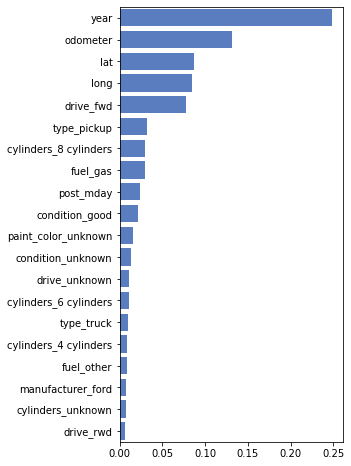

In [219]:
n=20
fig, ax = plt.subplots(figsize=(4, 8))
sns.set_color_codes("muted")
sns.barplot(x=features_importance[:n].values, y=features_importance[:n].index, color='b')
plt.show()
